# 1st Approach

In [6]:
################################
# 
################################
# Load required libraries
library(readr)
library(ggplot2)
library(e1071)
library(caret)
library(randomForest)
library(class)
library(dplyr)  # Make sure dplyr is loaded





Rows: 4801 Columns: 17
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (11): BROKERTITLE, TYPE, ADDRESS, STATE, MAIN_ADDRESS, ADMINISTRATIVE_AR...
dbl  (6): PRICE, BEDS, BATH, PROPERTYSQFT, LATITUDE, LONGITUDE

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "BROKERTITLE"                 "TYPE"                       
 [3] "PRICE"                       "BEDS"                       
 [5] "BATH"                        "PROPERTYSQFT"               
 [7] "ADDRESS"                     "STATE"                      
 [9] "MAIN_ADDRESS"                "ADMINISTRATIVE_AREA_LEVEL_2"
[11] "LOCALITY"                    "SUBLOCALITY"                
[13] "STREET_NAME"                 "LONG_NAME"                  
[15] "FORMATTED_ADDRESS"           "LATITUDE"                   
[17] "LONGITUDE"

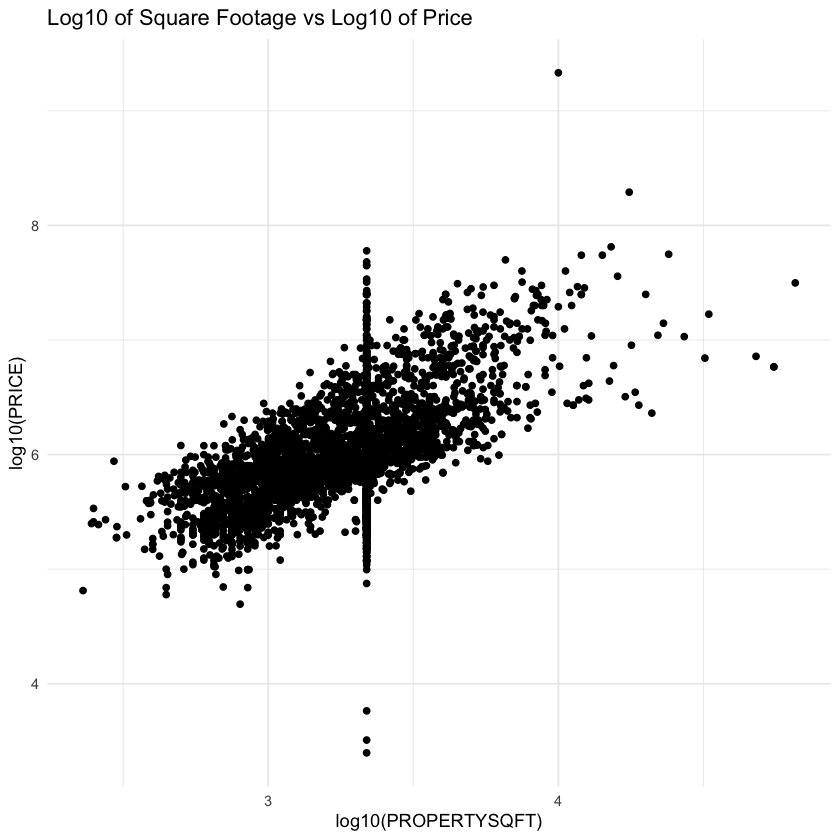

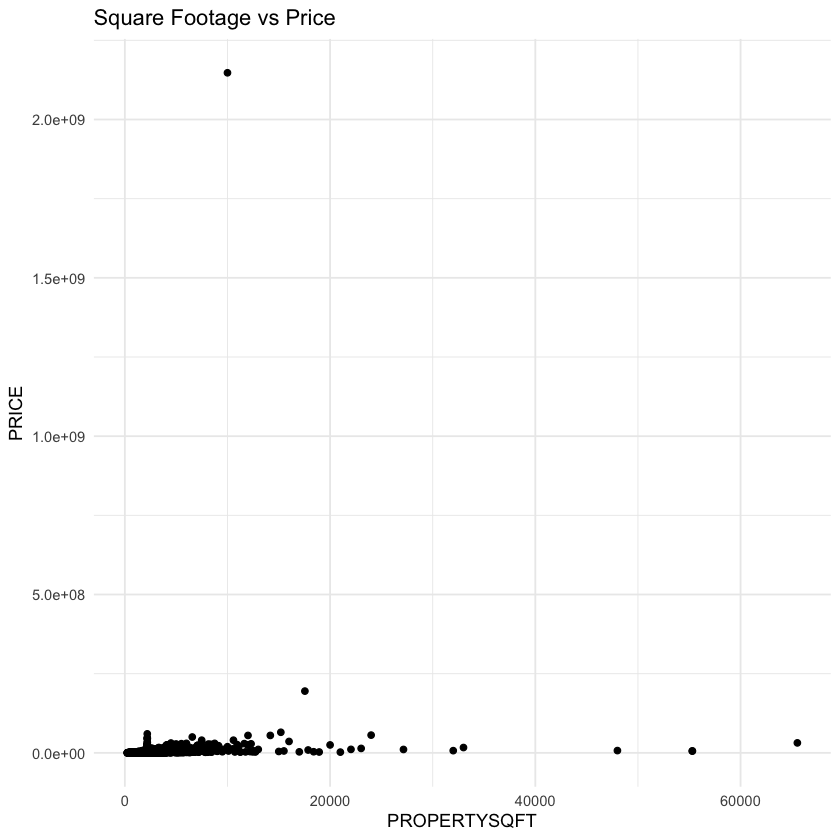

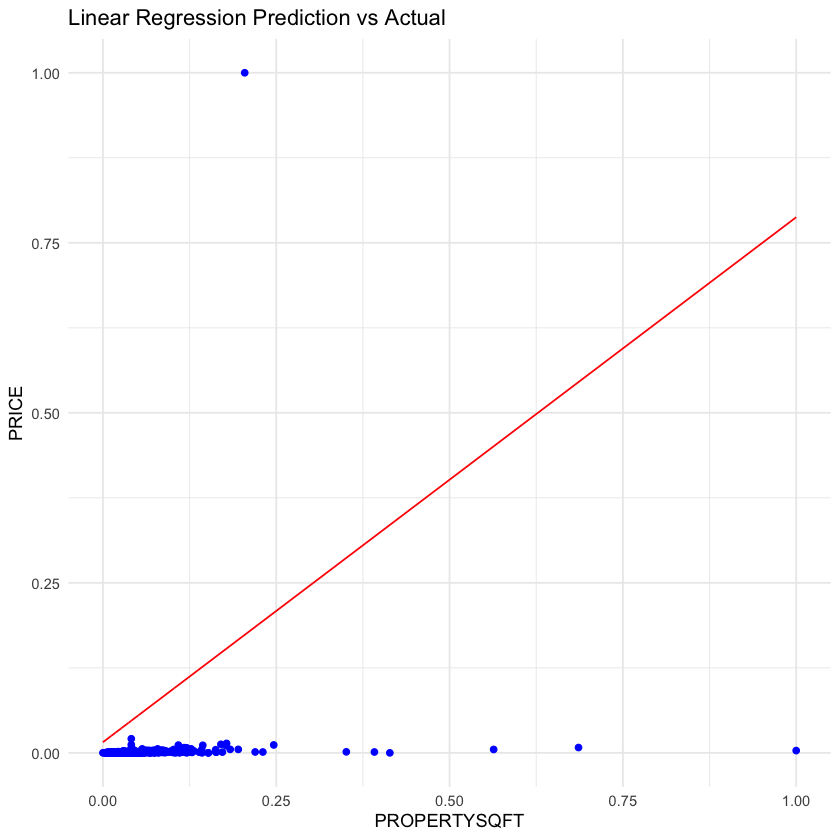

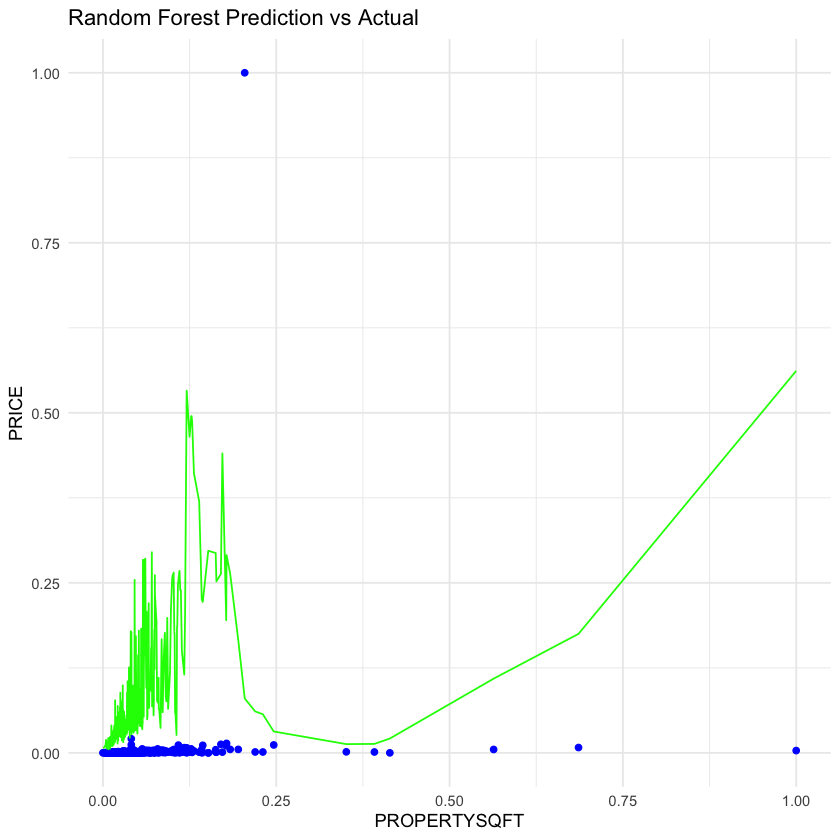

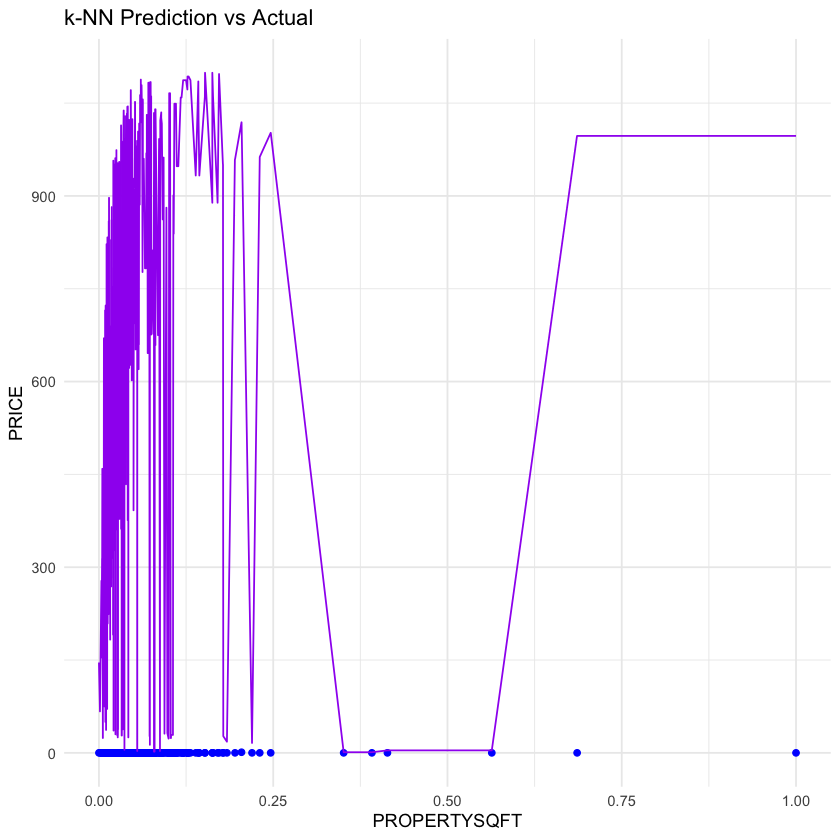

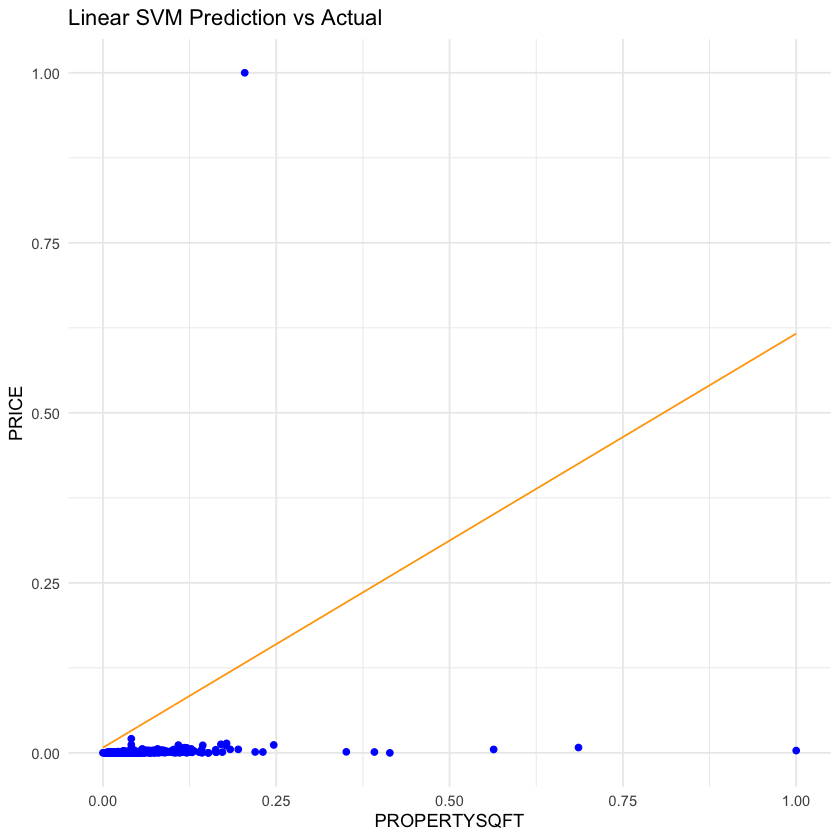

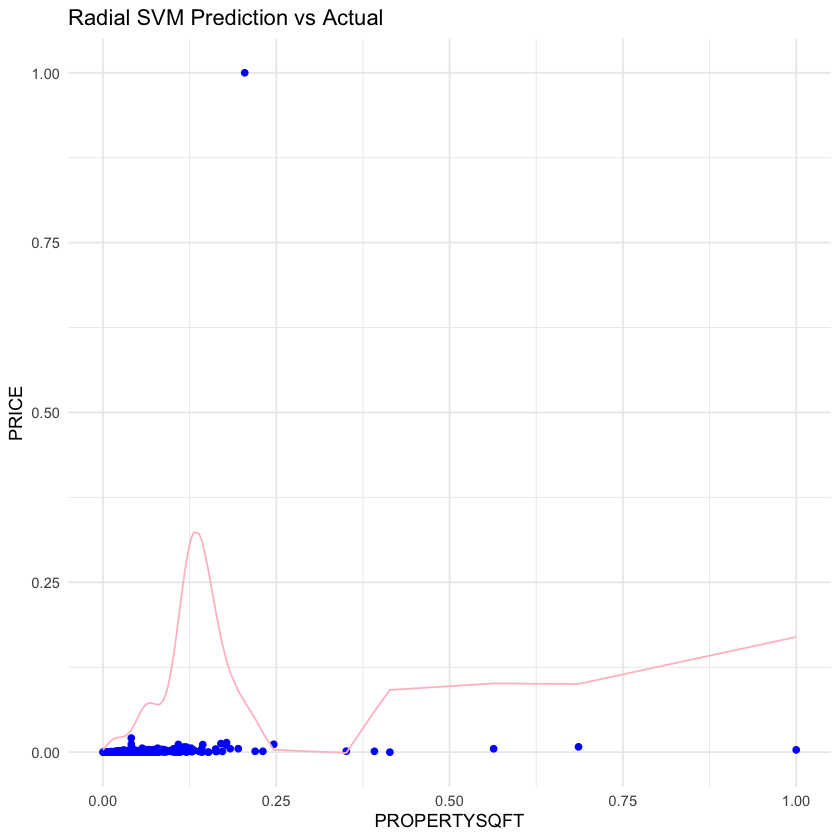

Linear Regression - MAE: 0.04785469  MSE: 0.004187724  RMSE: 0.06471263 
Random Forest - MAE: 0.09583215  MSE: 0.01627102  RMSE: 0.1275579 
k-NN - MAE: 764.3082  MSE: 680718.2  RMSE: 825.0565 
Linear SVM - MAE: 0.03304751  MSE: 0.002533071  RMSE: 0.05032962 
Radial SVM - MAE: 0.04009877  MSE: 0.00418173  RMSE: 0.06466629 
Tuned Radial SVM - MAE: 0.04009877  MSE: 0.00418173  RMSE: 0.06466629 


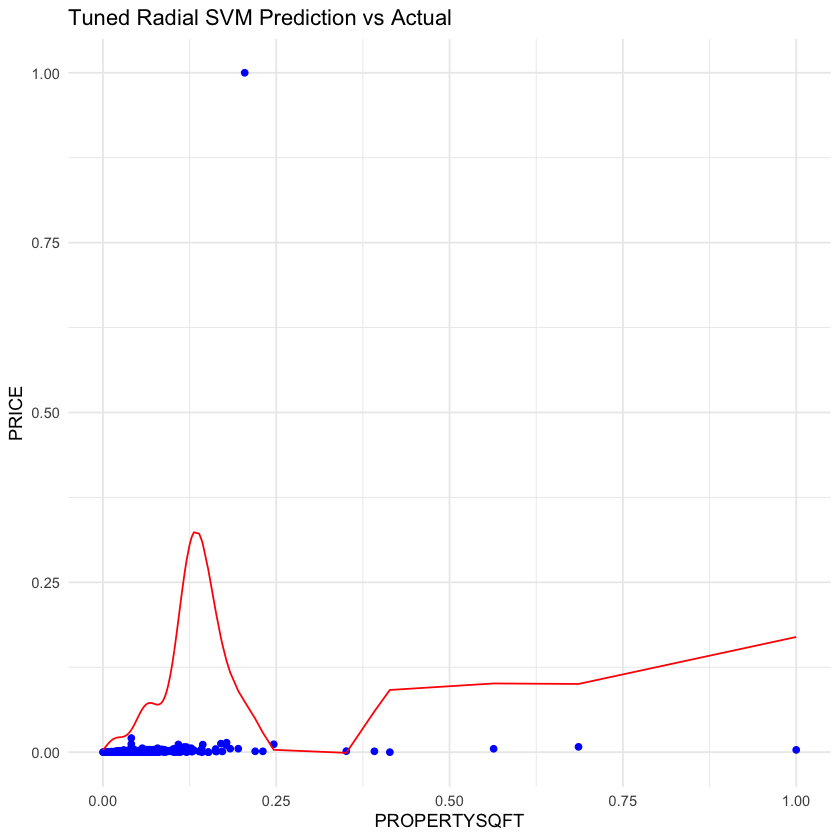

In [17]:

# Load dataset
NY_House_Dataset <- read_csv("NY-House-Dataset.csv")
dataset <- NY_House_Dataset

# Check column names
names(dataset)

# Plot dataset to visualize relationships
ggplot(dataset, aes(x = log10(PROPERTYSQFT), y = log10(PRICE))) +
  geom_point() +
  ggtitle("Log10 of Square Footage vs Log10 of Price") +
  theme_minimal()

ggplot(dataset, aes(x = PROPERTYSQFT, y = PRICE)) +
  geom_point() +
  ggtitle("Square Footage vs Price") +
  theme_minimal()

# Cleaning and preparation
dataset <- dataset %>%
  mutate(
    PRICE = as.numeric(gsub("[^0-9.-]", "", PRICE)),  # Correct column name
    PROPERTYSQFT = as.numeric(gsub("[^0-9.-]", "", PROPERTYSQFT))
  )

# Remove missing or zero values
dataset <- dataset[complete.cases(dataset) & dataset$PROPERTYSQFT > 0 & dataset$PRICE > 0, ]

# Feature selection
dataset <- dataset %>% select(PRICE, PROPERTYSQFT)

# Split data into training and test sets
set.seed(123)
train.indexes <- sample(nrow(dataset), 0.75 * nrow(dataset))
train <- dataset[train.indexes, ]
test <- dataset[-train.indexes, ]

# Normalize data
scale_data <- function(x) {
  return((x - min(x)) / (max(x) - min(x)))  # Normalization
}

train <- train %>%
  mutate(across(where(is.numeric), scale_data))

test <- test %>%
  mutate(across(where(is.numeric), scale_data))

##################################
# Model 1: Linear Regression
##################################

# Train Linear Regression model
lin.mod <- lm(PRICE ~ PROPERTYSQFT, data = train)
lin.pred <- predict(lin.mod, newdata = test)

# Calculate errors for Linear Regression
lin.error <- lin.pred - test$PRICE
lin.mae <- mean(abs(lin.error))
lin.mse <- mean(lin.error^2)
lin.rmse <- sqrt(lin.mse)

# Plotting the results of Linear Regression
ggplot(test, aes(x = PROPERTYSQFT, y = PRICE)) +
  geom_point(color = "blue") +
  geom_line(aes(x = PROPERTYSQFT, y = lin.pred), color = "red") +
  ggtitle("Linear Regression Prediction vs Actual") +
  theme_minimal()

##################################
# Model 2: Random Forest
##################################

# Train Random Forest model
rf.mod <- randomForest(PRICE ~ PROPERTYSQFT, data = train)
rf.pred <- predict(rf.mod, newdata = test)

# Calculate errors for Random Forest
rf.error <- rf.pred - test$PRICE
rf.mae <- mean(abs(rf.error))
rf.mse <- mean(rf.error^2)
rf.rmse <- sqrt(rf.mse)

# Plotting the results of Random Forest
ggplot(test, aes(x = PROPERTYSQFT, y = PRICE)) +
  geom_point(color = "blue") +
  geom_line(aes(x = PROPERTYSQFT, y = rf.pred), color = "green") +
  ggtitle("Random Forest Prediction vs Actual") +
  theme_minimal()

##################################
# Model 3: k-Nearest Neighbors (k=5)
##################################

# Train k-NN model (k=5)
knn.pred <- knn(train = train[, -which(names(train) == "PRICE")], 
                test = test[, -which(names(test) == "PRICE")], 
                cl = train$PRICE, k = 5)

# Convert predictions to numeric for error calculation
knn.pred <- as.numeric(knn.pred)

# Calculate errors for k-NN
knn.error <- knn.pred - test$PRICE
knn.mae <- mean(abs(knn.error))
knn.mse <- mean(knn.error^2)
knn.rmse <- sqrt(knn.mse)

# Plotting the results of k-NN
ggplot(test, aes(x = PROPERTYSQFT, y = PRICE)) +
  geom_point(color = "blue") +
  geom_line(aes(x = PROPERTYSQFT, y = knn.pred), color = "purple") +
  ggtitle("k-NN Prediction vs Actual") +
  theme_minimal()

##################################
# SVM Models (Linear, Radial, Tuned Radial)
##################################

# Linear SVM
svm.linear <- svm(PRICE ~ PROPERTYSQFT, data = train, kernel = "linear")
svm.linear.pred <- predict(svm.linear, newdata = test)
svm.linear.error <- svm.linear.pred - test$PRICE
svm.linear.mae <- mean(abs(svm.linear.error))
svm.linear.mse <- mean(svm.linear.error^2)
svm.linear.rmse <- sqrt(svm.linear.mse)

# Plotting the results of Linear SVM
ggplot(test, aes(x = PROPERTYSQFT, y = PRICE)) +
  geom_point(color = "blue") +
  geom_line(aes(x = PROPERTYSQFT, y = svm.linear.pred), color = "orange") +
  ggtitle("Linear SVM Prediction vs Actual") +
  theme_minimal()

# Radial SVM
svm.radial <- svm(PRICE ~ PROPERTYSQFT, data = train, kernel = "radial")
svm.radial.pred <- predict(svm.radial, newdata = test)
svm.radial.error <- svm.radial.pred - test$PRICE
svm.radial.mae <- mean(abs(svm.radial.error))
svm.radial.mse <- mean(svm.radial.error^2)
svm.radial.rmse <- sqrt(svm.radial.mse)

# Plotting the results of Radial SVM
ggplot(test, aes(x = PROPERTYSQFT, y = PRICE)) +
  geom_point(color = "blue") +
  geom_line(aes(x = PROPERTYSQFT, y = svm.radial.pred), color = "pink") +
  ggtitle("Radial SVM Prediction vs Actual") +
  theme_minimal()

# Tuned Radial SVM
tuned.svm <- tune.svm(PRICE ~ PROPERTYSQFT, data = train, kernel = "radial", 
                      gamma = 10^seq(-3, 2, 1), cost = 10^seq(-3, 2, 1), 
                      tune.control = tune.control(cross = 5))

# Train the tuned Radial SVM model
tuned.svm.model <- svm(PRICE ~ PROPERTYSQFT, data = train, kernel = "radial", 
                       gamma = tuned.svm$best.parameters$gamma, 
                       cost = tuned.svm$best.parameters$cost)

# Make predictions with the tuned SVM model
tuned.svm.pred <- predict(tuned.svm.model, newdata = test)

# Calculate errors for the tuned Radial SVM
tuned.svm.error <- tuned.svm.pred - test$PRICE
tuned.svm.mae <- mean(abs(tuned.svm.error))
tuned.svm.mse <- mean(tuned.svm.error^2)
tuned.svm.rmse <- sqrt(tuned.svm.mse)

# Plotting the results of Tuned Radial SVM
ggplot(test, aes(x = PROPERTYSQFT, y = PRICE)) +
  geom_point(color = "blue") +
  geom_line(aes(x = PROPERTYSQFT, y = tuned.svm.pred), color = "red") +
  ggtitle("Tuned Radial SVM Prediction vs Actual") +
  theme_minimal()

##################################
# Print the results
##################################
cat("Linear Regression - MAE:", lin.mae, " MSE:", lin.mse, " RMSE:", lin.rmse, "\n")
cat("Random Forest - MAE:", rf.mae, " MSE:", rf.mse, " RMSE:", rf.rmse, "\n")
cat("k-NN - MAE:", knn.mae, " MSE:", knn.mse, " RMSE:", knn.rmse, "\n")

cat("Linear SVM - MAE:", svm.linear.mae, " MSE:", svm.linear.mse, " RMSE:", svm.linear.rmse, "\n")
cat("Radial SVM - MAE:", svm.radial.mae, " MSE:", svm.radial.mse, " RMSE:", svm.radial.rmse, "\n")
cat("Tuned Radial SVM - MAE:", tuned.svm.mae, " MSE:", tuned.svm.mse, " RMSE:", tuned.svm.rmse, "\n")


# 2nd approach

Rows: 4801 Columns: 17
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (11): BROKERTITLE, TYPE, ADDRESS, STATE, MAIN_ADDRESS, ADMINISTRATIVE_AR...
dbl  (6): PRICE, BEDS, BATH, PROPERTYSQFT, LATITUDE, LONGITUDE

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


MODEL 1: LINEAR REGRESSION

Call:
lm(formula = log_PRICE ~ log_PROPERTYSQFT, data = train)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.96243 -0.19706 -0.05492  0.18447  2.44205 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)        2.3942     0.0628   38.12   <2e-16 ***
log_PROPERTYSQFT   1.1239     0.0195   57.62   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2918 on 2383 degrees of freedom
Multiple R-squared:  0.5822,	Adjusted R-squared:  0.582 
F-statistic:  3321 on 1 and 2383 DF,  p-value: < 2.2e-16


Regression Coefficients:
     (Intercept) log_PROPERTYSQFT 
        2.394182         1.123924 

Performance Metrics on Test Set:
       MAE        MSE       RMSE 
0.23671035 0.08695802 0.29488645 


MODEL 2: SVM WITH LINEAR KERNEL

Call:
svm(formula = log_PRICE ~ log_PROPERTYSQFT, data = train, kernel = "linear")


Parameters:
   SVM-Type:  eps-regression 
 SVM-Kernel:  

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


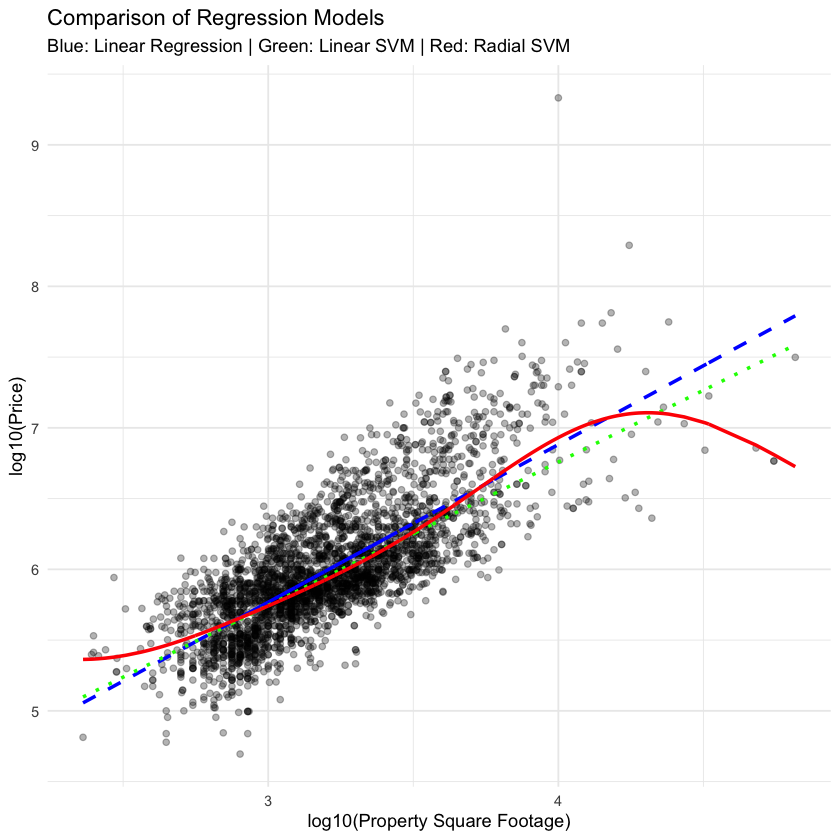

In [18]:
# Load required libraries
library(readr)
library(ggplot2)
library(e1071)
library(caret)

# Read data
NY_House_Dataset <- read_csv("NY-House-Dataset.csv")
dataset <- NY_House_Dataset

# Data cleaning - remove rows with PROPERTYSQFT = 2184.207862 (as in sample code)
dataset.sub0 <- dataset[-which(dataset$PROPERTYSQFT == 2184.207862), ]

# Convert to log scale for better modeling (as in sample code)
dataset.sub0$log_PRICE <- log10(dataset.sub0$PRICE)
dataset.sub0$log_PROPERTYSQFT <- log10(dataset.sub0$PROPERTYSQFT)

# Function to calculate evaluation metrics
calculate_metrics <- function(pred, actual) {
  err <- pred - actual
  mae <- mean(abs(err))
  mse <- mean(err^2)
  rmse <- sqrt(mse)
  return(c(MAE = mae, MSE = mse, RMSE = rmse))
}

# Set seed for reproducibility
set.seed(123)

# Split data into training (75%) and testing (25%) sets
train.indexes <- sample(nrow(dataset.sub0), 0.75 * nrow(dataset.sub0))
train <- dataset.sub0[train.indexes, ]
test <- dataset.sub0[-train.indexes, ]

cat("============================================\n")
cat("MODEL 1: LINEAR REGRESSION\n")
cat("============================================\n")

# Model 1: Linear Regression
lm.mod <- lm(log_PRICE ~ log_PROPERTYSQFT, data = train)
lm.pred <- predict(lm.mod, newdata = test)
lm.metrics <- calculate_metrics(lm.pred, test$log_PRICE)

# Print detailed output
print(summary(lm.mod))
cat("\nRegression Coefficients:\n")
print(coef(lm.mod))
cat("\nPerformance Metrics on Test Set:\n")
print(lm.metrics)

cat("\n\n============================================\n")
cat("MODEL 2: SVM WITH LINEAR KERNEL\n")
cat("============================================\n")

# Model 2: SVM with Linear Kernel
svm.linear <- svm(log_PRICE ~ log_PROPERTYSQFT, data = train, kernel = "linear")
svm.linear.pred <- predict(svm.linear, newdata = test)
svm.linear.metrics <- calculate_metrics(svm.linear.pred, test$log_PRICE)

# Print detailed output
print(summary(svm.linear))
cat("\nNumber of Support Vectors:\n")
print(svm.linear$nSV)
cat("\nPerformance Metrics on Test Set:\n")
print(svm.linear.metrics)

cat("\n\n============================================\n")
cat("MODEL 3: SVM WITH RADIAL KERNEL (OPTIMIZED)\n")
cat("============================================\n")

# Model 3: SVM with Radial Kernel (optimized)
# First perform parameter tuning
cat("\nTuning SVM parameters...\n")
tuned.svm <- tune.svm(log_PRICE ~ log_PROPERTYSQFT, 
                      data = train, 
                      kernel = "radial", 
                      gamma = 10^seq(-3, 2, 1), 
                      cost = 10^seq(-3, 2, 1),
                      tunecontrol = tune.control(cross = 5))

cat("\nBest Parameters Found:\n")
print(tuned.svm$best.parameters)

# Train with best parameters
svm.radial <- svm(log_PRICE ~ log_PROPERTYSQFT, 
                  data = train, 
                  kernel = "radial", 
                  gamma = tuned.svm$best.parameters$gamma, 
                  cost = tuned.svm$best.parameters$cost)

svm.radial.pred <- predict(svm.radial, newdata = test)
svm.radial.metrics <- calculate_metrics(svm.radial.pred, test$log_PRICE)

# Print detailed output
print(summary(svm.radial))
cat("\nNumber of Support Vectors:\n")
print(svm.radial$nSV)
cat("\nPerformance Metrics on Test Set:\n")
print(svm.radial.metrics)

# Combine all metrics for comparison
metrics.comparison <- rbind(
  Linear_Regression = lm.metrics,
  SVM_Linear = svm.linear.metrics,
  SVM_Radial = svm.radial.metrics
)

cat("\n\n============================================\n")
cat("MODEL COMPARISON: TEST SET PERFORMANCE\n")
cat("============================================\n")
print(metrics.comparison)

# Monte Carlo Cross Validation (100 iterations) for more robust evaluation
k <- 100
metrics.mc <- list(
  lm = matrix(0, nrow = k, ncol = 3, dimnames = list(NULL, c("MAE", "MSE", "RMSE"))),
  svm_linear = matrix(0, nrow = k, ncol = 3, dimnames = list(NULL, c("MAE", "MSE", "RMSE"))),
  svm_radial = matrix(0, nrow = k, ncol = 3, dimnames = list(NULL, c("MAE", "MSE", "RMSE")))
)

set.seed(123) # for reproducibility
cat("\n\nRunning Monte Carlo Cross Validation (100 iterations)...\n")
pb <- txtProgressBar(min = 0, max = k, style = 3)
for (i in 1:k) {
  # Split data
  train.indexes <- sample(nrow(dataset.sub0), 0.75 * nrow(dataset.sub0))
  train <- dataset.sub0[train.indexes, ]
  test <- dataset.sub0[-train.indexes, ]
  
  # Linear Regression
  lm.mod <- lm(log_PRICE ~ log_PROPERTYSQFT, data = train)
  lm.pred <- predict(lm.mod, newdata = test)
  metrics.mc$lm[i, ] <- calculate_metrics(lm.pred, test$log_PRICE)
  
  # SVM Linear
  svm.linear <- svm(log_PRICE ~ log_PROPERTYSQFT, data = train, kernel = "linear")
  svm.linear.pred <- predict(svm.linear, newdata = test)
  metrics.mc$svm_linear[i, ] <- calculate_metrics(svm.linear.pred, test$log_PRICE)
  
  # SVM Radial (using previously found best parameters)
  svm.radial <- svm(log_PRICE ~ log_PROPERTYSQFT, 
                    data = train, 
                    kernel = "radial", 
                    gamma = tuned.svm$best.parameters$gamma, 
                    cost = tuned.svm$best.parameters$cost)
  svm.radial.pred <- predict(svm.radial, newdata = test)
  metrics.mc$svm_radial[i, ] <- calculate_metrics(svm.radial.pred, test$log_PRICE)
  
  setTxtProgressBar(pb, i)
}
close(pb)

# Calculate mean metrics from Monte Carlo simulation
mean.metrics <- rbind(
  Linear_Regression_MC = colMeans(metrics.mc$lm),
  SVM_Linear_MC = colMeans(metrics.mc$svm_linear),
  SVM_Radial_MC = colMeans(metrics.mc$svm_radial)
)

cat("\n\n============================================\n")
cat("MONTE CARLO CROSS VALIDATION RESULTS (100 ITERATIONS)\n")
cat("============================================\n")
print(mean.metrics)

# Visualization of all models
ggplot(dataset.sub0, aes(x = log_PROPERTYSQFT, y = log_PRICE)) +
  geom_point(alpha = 0.3) +
  geom_line(aes(x = log_PROPERTYSQFT, y = predict(lm.mod, dataset.sub0)), 
            color = "blue", size = 1, linetype = "dashed") +
  geom_line(aes(x = log_PROPERTYSQFT, y = predict(svm.linear, dataset.sub0)), 
            color = "green", size = 1, linetype = "dotted") +
  geom_line(aes(x = log_PROPERTYSQFT, y = predict(svm.radial, dataset.sub0)), 
            color = "red", size = 1) +
  labs(title = "Comparison of Regression Models",
       subtitle = "Blue: Linear Regression | Green: Linear SVM | Red: Radial SVM",
       x = "log10(Property Square Footage)",
       y = "log10(Price)") +
  theme_minimal()